In [1]:
import numpy as np
#from LogGabor import LogGaborFit
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
import pickle
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
import torch.nn.functional as f

from SDPC_PCB.DataTools import DataBase, ssim
from SDPC_PCB.Network import LayerPC, Network
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
from SDPC_PCB.DataTools import DataBase

from SDPC_PCB.Optimizers import mySGD, myAdam
import torch.nn.functional as f
import torch.nn as nn
import torch
import time
import tensorboardX
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torchvision.utils import make_grid
import numpy as np
from tensorboardX import SummaryWriter
import pickle
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
import torch.optim as optim
from SDPC.Monitor import Monitor
import math

import matplotlib.pyplot as plt
from LogGabor import LogGaborFit
from scipy.stats import wilcoxon

In [2]:
cmap1=plt.get_cmap('tab20c')
cmap2=plt.get_cmap('tab20b')
color_fb=[cmap1(21),cmap1(3),cmap1(2),cmap1(1),cmap1(0)]

## Fig 3a

In [3]:
data_path = '../DataSet/STL10'

transform = Compose([ToTensor(),
                    to_cuda(),
                    whitening((96,96),f_0=0.5),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((96,96))])

dataset = STL10(data_path, transform=transform, download=False, split='test')

DataBase = DataLoader(dataset, batch_size=40, shuffle=False, drop_last=True)

In [16]:
save_simulation = False

where = 'Savings/STL/'
model_name = 'STL_[0.4,1.6]_b=1.pkl'
saving_path = where + 'Saving_STL_Fig3a.pkl'
feedback_list = [0,1,2,3,4]
nb_batch = 30
nb_image=nb_batch*40

all_sparsity = torch.zeros(nb_image,len(feedback_list),2)
all_activity = torch.zeros(len(feedback_list),2)

if save_simulation == True:
    
    for k_FB in feedback_list:
        idx_model=k_FB
        k=0
        model_type = model_name[0:8]
        name = model_name
        print(name)

        path = where + name
        with open(path, 'rb') as file:
            out = pickle.load(file)
        Net = out['Net']
        
        for i in range(Net.nb_layers):
            Net.layers[i].b = k_FB
        Loss = ML_Lasso(Net, [0.4,1.6])
        Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=1e-4, mode='eigen', accell=True)
        histo = [0,0]
        
        for idx_batch, data in enumerate(DataBase):
            batch = data[0].cuda()
            gamma, it, Loss_G, delta = Pursuit.coding(batch)

            for i in range(Net.nb_layers):
                nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
                volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
                all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
                freq = (gamma[i]!=0).view(batch.size(0),gamma[i].size(1),-1)
                freq = freq.sum(-1).sum(0)
            
            k+=batch.size(0)
            if k >= nb_image:
                break        

    Exp = {'model_name': feedback_list,
            'sparsity' : all_sparsity}
    
    with open(saving_path, 'wb') as file:
        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)
else : 
    with open(saving_path, 'rb') as file:
        Exp = pickle.load(file)
    

STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl


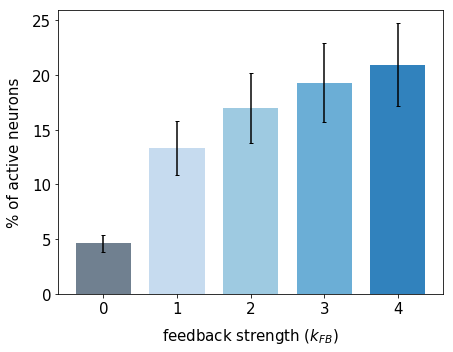

In [17]:
save_fig = False
figsize = (6.4,5)

labels = ['$k_{FB}=0$','$k_{FB}=1$','$k_{FB}=2$','$k_{FB}=3$','$k_{FB}=4$']

mean_sp = Exp['sparsity'].mean(dim=0)
std_sp = Exp['sparsity'].std(dim=0)
model_name_list = Exp['model_name']
list_layer= np.arange(len(model_name_list))
N = len(list_layer)
position = [1 + 1*i for i in range(N)] 


width = 0.75 

fig = plt.figure(figsize=figsize)

plot_SDPC = plt.bar(position, 100-mean_sp[:,0].numpy(),  yerr=std_sp[:,0].numpy(), align='center',
                 capsize=2,width=0.75, color=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)])

plt.ylabel('% of active neurons', fontsize=15, labelpad=10)
xticks_position = [1 +1*i for i in range(N)]
plt.xlabel('feedback strength '+ r'($k_{FB}$)', fontsize=15, labelpad=10)
plt.xticks(xticks_position,list_layer , fontsize=15)
#plt.title('a) - First Layer sparsity when increasing the \nfeedback strenght', fontsize=15, pad=15)
#plt.ylim()
plt.yticks([0,5,10,15,20,25], fontsize=15)
#plt.title('i) - AT&T', fontsize=15)
'''
for i in range(5):
    plot_SDPC[i].set_label(labels[i])


plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize=15)
'''
plt.tight_layout()

if save_fig == True:
    '''
    plt.savefig('Fig3/histo_legend.png', bbox_inches = 'tight', pad_inches = 0.5, dpi= 400)
    '''
    plt.savefig('Savings/Fig/Fig3/Fig3a.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
    

plt.show()

### Stastistical tests

In [18]:
from decimal import Decimal

sp = Exp['sparsity']

print('p_value Wilcoxon signed rank')
to_print=''
for i in range(5):
    for j in range(5):
        if i>j:
            test = wilcoxon(sp[:,j,0],sp[:,i,0], alternative='greater')
            #test = ttest_rel(relative_coli_R1_ref[:,i],relative_coli_R1_ref[:,j])
            to_print+='fb={0}/fb={1} = {2:0.2E} -- '.format(i,j,Decimal(test[1]))
    to_print+='\n'
print('p_value \n' + to_print)

p_value Wilcoxon signed rank
p_value 

fb=1/fb=0 = 4.07E-198 -- 
fb=2/fb=0 = 4.07E-198 -- fb=2/fb=1 = 4.07E-198 -- 
fb=3/fb=0 = 4.07E-198 -- fb=3/fb=1 = 4.07E-198 -- fb=3/fb=2 = 4.07E-198 -- 
fb=4/fb=0 = 4.07E-198 -- fb=4/fb=1 = 4.07E-198 -- fb=4/fb=2 = 4.07E-198 -- fb=4/fb=3 = 4.07E-198 -- 



## Fig 3b

In [19]:
from SDPC_PCB.DataTools import DataBase

data_path ='../DataSet/CF_DB_testing/'

LCN_params = {'kernel_size':11,
'sigma':0.5,
'rgb':True}

mask_params={'n': 10}# default is 10

whitening_params={'f_0':0.5,
'n':2}

Data_load_param = {'batch_size': 40,
'do_LCN': True,
'LCN_params': LCN_params,
'do_mask': True,
'mask_params': mask_params,
'do_whitening': True,
'whitening_params': whitening_params,
'do_z_score': True,
'return_idx': False}

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124), reshaped_size=(120,171),**Data_load_param, shuffle=False)

In [ ]:
save_simulation = False

where = 'Savings/CFD/'
model_name = 'CFD_[0.3,1.6]_b=1.pkl'
saving_path = 'Savings/CFD/Fig3b.pkl'
feedback_list = [0,1,2,3,4]
nb_batch = 10
nb_image=nb_batch*40

all_sparsity = torch.zeros(nb_image,len(feedback_list),2)
all_activity = torch.zeros(len(feedback_list),2)

if save_simulation == True:
    
    for k_FB in feedback_list:
        idx_model=k_FB
        k=0
        model_type = model_name[0:8]
        name = model_name
        print(name)

        path = where + name
        with open(path, 'rb') as file:
            out = pickle.load(file)
        Net = out['Net']
        for i in range(Net.nb_layers):
            Net.layers[i].b = k_FB
        Loss = ML_Lasso(Net, [0.3,1.6])
        Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=5e-3, mode='eigen', accell=True)
        histo = [0,0]
        
        for idx_batch, data in enumerate(Facedata.data):
            batch = data[0].cuda()
            gamma, it, Loss_G, delta = Pursuit.coding(batch)

            for i in range(Net.nb_layers):
                nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
                volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
                all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
            k+=batch.size(0)
            if k >= nb_image:
                break

        
        
        

    Exp = {'model_name': feedback_list,
            'sparsity' : all_sparsity}

    
    with open(saving_path, 'wb') as file:
        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)
else : 
    with open(saving_path, 'rb') as file:
        Exp = pickle.load(file)
    

CFD_[0.3,1.6]_b=1.pkl
CFD_[0.3,1.6]_b=1.pkl
CFD_[0.3,1.6]_b=1.pkl
CFD_[0.3,1.6]_b=1.pkl
CFD_[0.3,1.6]_b=1.pkl


In [ ]:
save_fig = False
figsize = (6.4,5)



mean_sp = Exp['sparsity'].mean(dim=0)
std_sp = Exp['sparsity'].std(dim=0)
model_name_list = Exp['model_name']
list_layer= np.arange(len(model_name_list))
N = len(list_layer)
position = [1 + 1*i for i in range(N)] 


width = 0.75 

fig = plt.figure(figsize=figsize)

plot_SDPC = plt.bar(position, 100-mean_sp[:,0].numpy(),  yerr=std_sp[:,0].numpy(), align='center',
                 capsize=2,width=0.75, color=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)])

plt.ylabel('% of active neurons', fontsize=15, labelpad=10)
xticks_position = [1 +1*i for i in range(N)]
plt.xlabel('feedback strength '+ r'($k_{FB}$)', fontsize=15, labelpad=10)
plt.xticks(xticks_position,list_layer , fontsize=15)
#plt.title('a) - First Layer sparsity when increasing the \nfeedback strenght', fontsize=15, pad=15)

plt.yticks([0,4,8,12,16,20], fontsize=15)

plt.tight_layout()
if save_fig == True:
    plt.savefig('Savings/Fig/Fig3/Fig3b.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)


plt.show()
res = 100-mean_sp[:,0]
diff = [res[i+1] - res[i] for i in range(4)]

print(100-mean_sp[:,0].numpy())
print(diff)

print(std_sp[:,0])





### Statisticial tests

In [ ]:
from decimal import Decimal

sp = Exp['sparsity']

print('p_value Wilcoxon signed rank')
to_print=''
for i in range(5):
    for j in range(5):
        if i>j:
            test = wilcoxon(sp[:,j,0],sp[:,i,0], alternative='greater')
            to_print+='fb={0}/fb={1} = {2:0.2E} -- '.format(i,j,Decimal(test[1]))
    to_print+='\n'
print('p_value \n' + to_print)
        


